## Here is the notebook describing a quantum state tomogragraphy experiment performed on a circuit designed to produce a GHZ state.

### First I will do a brief overview of the GHZ state and the functioning of Qiskit, then the tomography experiment, followed by some error mitigation. 

Below we import all the neccessary libraries for the investigation.

In [35]:
import numpy as np
import time
from copy import deepcopy

# Importing standard Qiskit libraries
from qiskit import * 
import qiskit.quantum_info as qi
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
import qiskit.providers.ibmq.jupyter
# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter

# Loading your IBM Quantum account(s), this provider allows access to the IBMQ chips
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-12-02 11:25:57,480: Credentials are already in use. The existing account in the session will be replaced.


First a brief introduction to the GHZ state.

The GHZ state is a tripartite entangled state of the following form.
$$|GHZ\rangle = \frac{1}{\sqrt{2}} [|000\rangle+|111\rangle]$$

It is similar in form to the one of the bell states typically studied when reading about bipartite entanglement.

In Qiskit, the first thing we do when creating a quantum circuit to do anything is define our quantum register. This essentially defines how many qubits we wish to use in our experiment. Obviously to produce the GHZ state we will need a quantum register of 3 qubits. So we create this now.

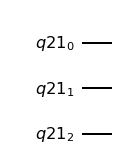

In [23]:
# Create a Quantum Circuit acting on a quantum register of three qubits
qr = QuantumRegister(3)
circ = QuantumCircuit(qr)
circ.draw()
#the draw function allows us to nicely visualise our quantum circuits, though the print function also works it is less visually appealing

There are 3 gates that need to be implemented to create the above state
1. A Hadamard gate applied to qubit 0
2. A C-NOT gate applied to qubit 1 with qubit 0 as control
2. A C-NOT gate applied to qubit 2 with qubit 0 as control.

Lets create a circuit out of these 3 gate operations now and see what the circuit looks like.

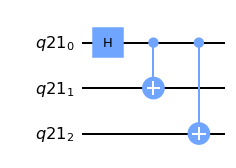

In [24]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
circ.draw()

Now before we build and run any quantum circuit, we need to choose a backend. This is the actual chip and/or simulator that will be used to implement the gates. Since I want to generate legitimate entanglement for this experiment I will be choosing an actual quantum chip available from IBM via cloud access, and not a simulator. Using the following method I can print out all available backends to my acount.

In [25]:
provider.backends()  #here I print out all of the backends available

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

As you can see there are a number of real quantum chips as well as simulators available to the public account. The following code can be used to choose our backend and also display some info on its architecture/performance.

In [26]:
system = provider.get_backend('ibmq_belem') #choosing a backend and looking at its architecture
system

Card(children=[Toolbar(children=[ToolbarTitle(children=['ibmq_belem @ (ibm-q/open/main)'], style_='color:white…

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

If we look at the coupling map in the diagram, or even in the list given at the bottom of the information. This chip hasnt the ability to perform a C-NOT gate with any two qubits acting as control and target. This limited coupling map is a feature on all of the chips. This isnt the end of the world however, Qiskit has a transpiler that will create the neccesary adjustments to the circuit created so as to run on the chip correctly. Some qubits therefore will just be used as ancillas etc.

So the circuit I wish to implement, with measurement included, will look like the following.

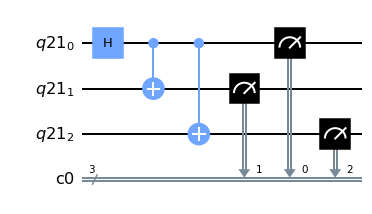

In [27]:
# Create a Quantum Circuit acting on a quantum register of three qubits
cr = ClassicalRegister(3) #the classical register is where we record the measurement results

circ = QuantumCircuit(qr,cr)

# Add a H gate on qubit 1, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 2, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 3, putting
# the qubits in a GHZ state.
circ.cx(0, 2)

circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)

circ.draw()

However after the transpiling process, we can see the actual circuit will look like.

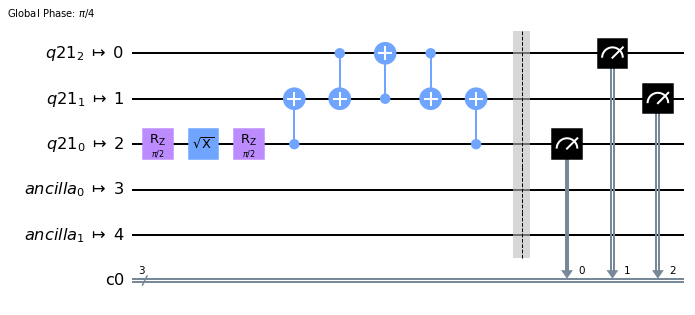

In [29]:
circ1 = transpile(circ,backend=system) #the transpiler must receive the circuit and backend as arguments
circ1.draw()

#outputstate = result.get_statevector(circ, decimals=3) #this returns the average statevector from the job
#plot_state_city(outputstate)             #now we plot a cityscape plot to visualise the density matrix.
#print(outputstate)

Now I can pass this transpiled circuit to the backend for execution

In [ ]:
# Create a Quantum Program for execution 
job = system.run(circ1)
result = job.result()

Can I measure in a different basis on the same circuit? This can actually be done quite simply by cahgning the basis of the qubits before measurement. To measure in the X basis, we apply $H$ to the qubits before measurement, and to measure in the Y basis we apply $S^{\dagger}H$ We can visualise this below

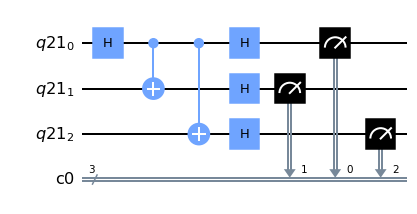

In [30]:
# Create a Quantum Circuit acting on a quantum register of three qubits, and we measure in X basis
circ1 = QuantumCircuit(qr,cr)

# Add a H gate on qubit 1, putting this qubit in superposition.
circ1.h(0)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 2, putting
# the qubits in a Bell state.
circ1.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 3, putting
# the qubits in a GHZ state.
circ1.cx(0, 2)

for i in range(3):
    circ1.h(i)

circ1.measure(0,0)
circ1.measure(1,1)
circ1.measure(2,2)

circ1.draw()

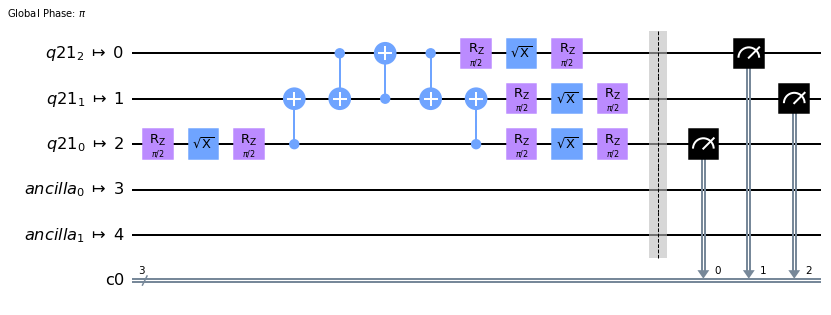

In [31]:
circ1 = transpile(circ1,backend=system)
circ1.draw()

In [ ]:
# Create a Quantum Program for execution 
job = system.run(circ1)
result = job.result()

For a $Y$ basis measurement, we need to apply first a Hadamard, followed then by an SDG gate. This looks llke the following

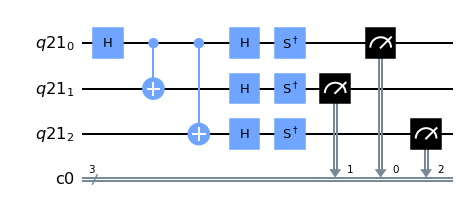

In [32]:
# Create a Quantum Circuit acting on a quantum register of three qubits, and we measure in X basis
circ2 = QuantumCircuit(qr,cr)

# Add a H gate on qubit 1, putting this qubit in superposition.
circ2.h(0)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 2, putting
# the qubits in a Bell state.
circ2.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 1 and target qubit 3, putting
# the qubits in a GHZ state.
circ2.cx(0, 2)

for i in range(3):
    circ2.h(i)
    circ2.sdg(i)

circ2.measure(0,0)
circ2.measure(1,1)
circ2.measure(2,2)

circ2.draw()

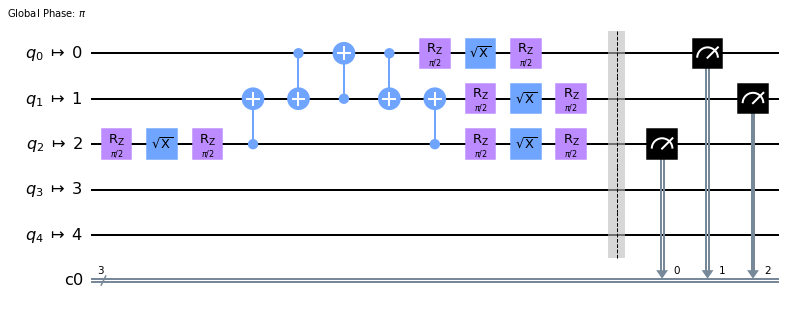

In [33]:
circ1 = transpile(circ1,backend=system)
circ1.draw()

## Tomography

Now we switch our attention to state tomography. This is the process of measuring a quantum state in different basis, and using the results to build up some statistics in an attempt to reconstruct the density matrix of the state. For the GHZ state, we measure the 3 qubits in the Pauli X,Y,Z bases. In general then, we can see the total number of quantum circuits one would need to create is $3^{n}$, where in each circuit we measure the qubits in some different combination of bases. E.g {XXY}, {ZYX} etc.

This could be an arduous process, thankfully qiskit has some very useful functions etc to streamline this in its ignis package.

Since the tomography functions will be doing the work regarding measurements etc, we need to simply pass to it a raw circuit with no measurements. So we create the neccesary circuit down below.

In [39]:
# Create a state preparation circuit
GHZ = QuantumCircuit(qr)
GHZ.h(0)
for j in range(2):
    GHZ.cx(qr[0], qr[j + 1])
    
print(GHZ)

       ┌───┐          
q21_0: ┤ H ├──■────■──
       └───┘┌─┴─┐  │  
q21_1: ─────┤ X ├──┼──
            └───┘┌─┴─┐
q21_2: ──────────┤ X ├
                 └───┘


Now later when we want to compute the fidelity of the quantum state we generate w.r.t a genuine GHZ state, we will need a reference. So we generate the expected state using the statevector.from_instruction method which reads the circuit and outputs what the ideal output would be.

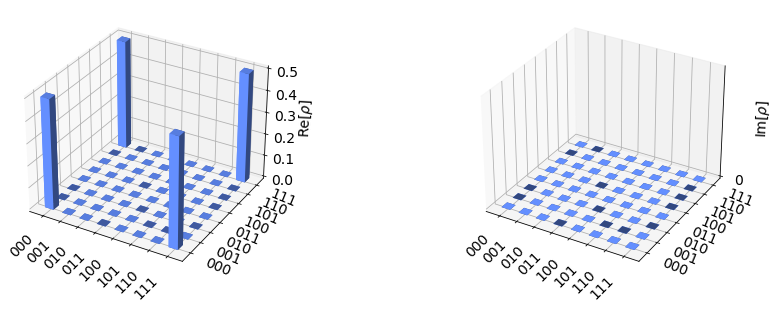

In [42]:
# Get ideal output state for comparison, and visualise its density matrix.
target_state_GHZ = qi.Statevector.from_instruction(GHZ)
plot_state_city(target_state_GHZ)

The following uses the state_tomography_circuits function to generate $3^{3} = 27$ ciruits to run on the backend, each one differing simply by the combination of measurements. It then runs these circuits on the backend. I will do on a simulator here since there is usually queues for the legitimate chips.

In [44]:
# Generate circuits and run on belem system
t = time.time()
qst_GHZ = state_tomography_circuits(GHZ, qr)
job = qiskit.execute(qst_GHZ, Aer.get_backend('qasm_simulator'), shots=5000)
#job = qiskit.execute(qst_GHZ, system, shots=5000)

/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning:

The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.

/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning:

The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.

/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning:

The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.

/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning:

The QuantumCi

Now we can print out job.result() if we wish, however it is hard to gain much insight from this seeing as it is just dictionaries of data, recording the measurement counts for each mesurement bases. What is useful is the StateTomographyFitter method, which fits the data via maximum likelihood estimation to a density matrix.

Time taken: 615.2094974517822
State fidelity: F = 0.99465


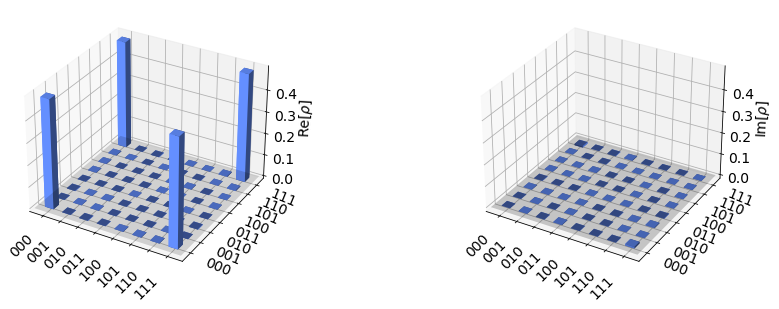

In [53]:
# Extract tomography data so that counts are indexed by measurement configuration
tomo_GHZ = StateTomographyFitter(job.result(), qst_GHZ) # we pass the results and circuits as arguments

rho_fit_GHZ = tomo_GHZ.fit(method='lstsq')
print('Time taken:', time.time() - t)
print('State fidelity: F = {:.5f}'.format(qi.state_fidelity(rho_fit_GHZ, target_state_GHZ)))

plot_state_city(rho_fit_GHZ)

Obviously a real quantum chip would not be this accurate, below I include the results for a real simlation on the IBMQ_belem chip.

Time taken: 2005.9693794250488
State fidelity: F = 0.79091


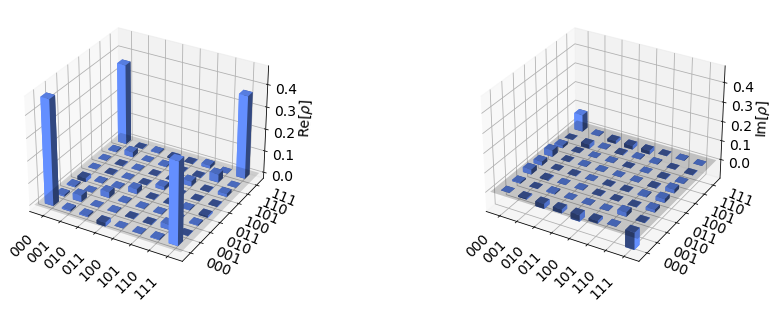

In [54]:
job = qiskit.execute(qst_GHZ, system, shots=5000)

# Extract tomography data so that counts are indexed by measurement configuration
tomo_GHZ = StateTomographyFitter(job.result(), qst_GHZ)

rho_fit_GHZ = tomo_GHZ.fit(method='lstsq')
print('Time taken:', time.time() - t)
print('State fidelity: F = {:.5f}'.format(qi.state_fidelity(rho_fit_GHZ, target_state_GHZ)))

plot_state_city(rho_fit_GHZ)

## Some error mitigation
Here I implement some basic error mitigation techniques to imporove the readout fidelity.
The basic idea is that we take our qubit register, and measure the readout error for various output states for a given backend. This can then be used to improve our readout of he tomography result from earlier.

In [82]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

In [78]:
qn = 3
qubit_list = range(qn)
#below creates 8 circuits, one for each possible output state
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

In [69]:
job_c = qiskit.execute(meas_calibs, backend=system, shots = 5000)
meas_result = job_c.result()
#this outputs the measurements results for each circuit, the discrepencies with the expeted 
#values can show us the errors.

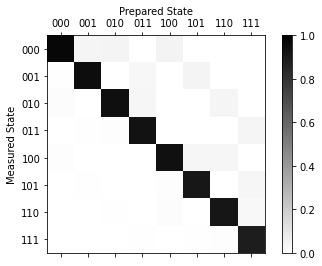

In [84]:
#the calibration plot shows the accuracy of the measurements for each state.
meas_fitter = CompleteMeasFitter(meas_result,state_labels,circlabel='mcal')
meas_fitter.plot_calibration()

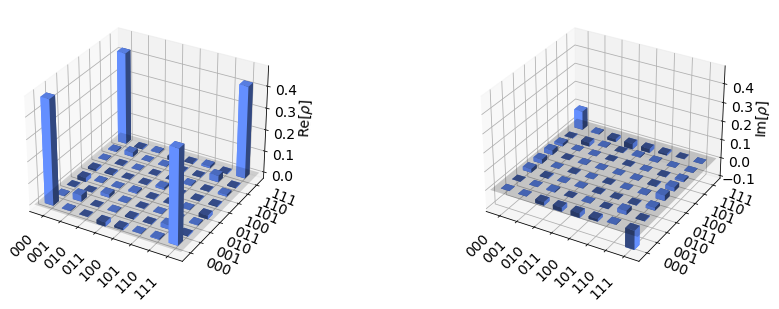

In [87]:
#first line corrects our previous measurements from th tomography experiment by knowing the readout 
#errors
result_em = meas_fitter.filter.apply(job.result())

#we re-fit the density matrix with this new result
tomo_em = StateTomographyFitter(result_em, qst_GHZ)
plot_state_city(tomo_em.fit())

In [88]:
rho_fit_GHZ = tomo_em.fit(method='lstsq')
print('State fidelity: F = {:.5f}'.format(qi.state_fidelity(rho_fit_GHZ, target_state_GHZ)))

State fidelity: F = 0.88195


We have managed to boost fidelity from 79% to 88%, worthwhile.